In [4]:
pip install torch torchvision matplotlib

  Using cached torch-2.7.1-cp312-cp312-win_amd64.whl.metadata (28 kB)
  Using cached torchvision-0.22.1-cp312-cp312-win_amd64.whl.metadata (6.1 kB)
  Using cached matplotlib-3.10.5-cp312-cp312-win_amd64.whl.metadata (11 kB)
  Using cached typing_extensions-4.14.1-py3-none-any.whl.metadata (3.0 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached setuptools-80.9.0-py3-none-any.whl.metadata (6.6 kB)
  Using cached pillow-11.3.0-cp312-cp312-win_amd64.whl.metadata (9.2 kB)
  Using cached contourpy-1.3.3-cp312-cp312-win_amd64.whl.metadata (5.5 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
  Using cached fonttools-4.59.0-cp312-cp312-win_amd64.whl.metadata (110 kB)
  Using cached kiwisolver-1.4.8-cp312-cp312-win_amd64.whl.metadata (6.3 kB)
  Using cached pyparsing-3.2.3-py3-none-any.whl.metadata (5.0 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
  Using cached MarkupSafe-3.0.2-cp312-cp312-win_amd64.whl.metadata (4.1 kB)
Us

In [41]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [42]:
# Define transformations - basic preprocessing only since using pre-augmented dataset
train_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 requires 299x299 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # Standard ImageNet normalization
                         std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((299, 299)),  # Inception v3 requires 299x299 input
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

In [52]:
# Paths
train_dir = "Dataset_Augmented/Train"
test_dir = "Dataset/Test"

# Load datasets
train_dataset = datasets.ImageFolder(train_dir, transform=train_transforms)
test_dataset = datasets.ImageFolder(test_dir, transform=test_transforms)

# Create loaders
BATCH_SIZE = 32

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Class mapping and dataset info
class_names = train_dataset.classes
print("Classes:", class_names)
print(f"\nDataset Information:")
print(f"Training images: {len(train_dataset)}")
print(f"Test images: {len(test_dataset)}")
print(f"Total images: {len(train_dataset) + len(test_dataset)}")

# Show class distribution
for i, class_name in enumerate(class_names):
    train_count = len([x for x in train_dataset.samples if x[1] == i])
    test_count = len([x for x in test_dataset.samples if x[1] == i])
    print(f"{class_name}: {train_count} train, {test_count} test")

Classes: ['Kidney_stone', 'Normal']

Dataset Information:
Training images: 13077
Test images: 346
Total images: 13423
Kidney_stone: 5625 train, 165 test
Normal: 7452 train, 181 test


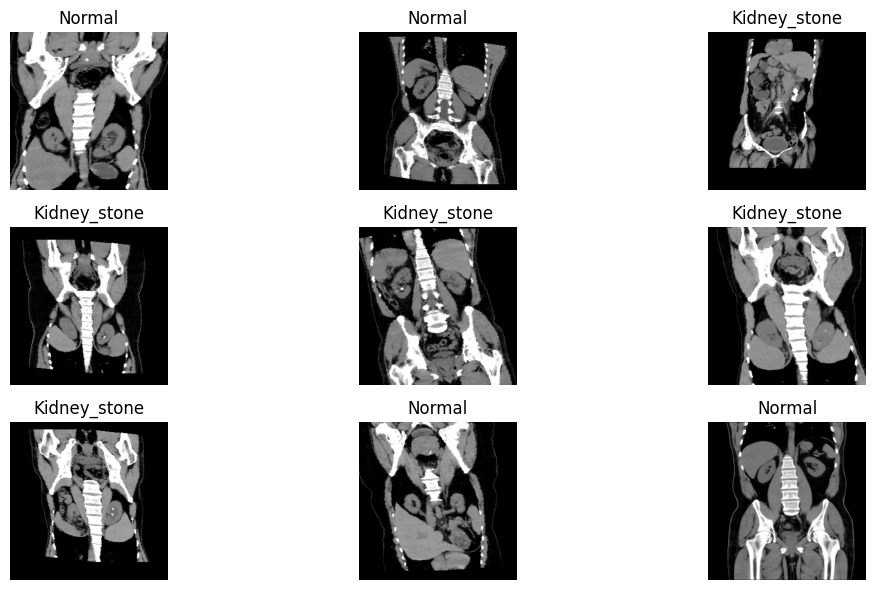

In [53]:
def imshow(img, title):
    img = img.numpy().transpose((1, 2, 0))
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]
    img = std * img + mean  # Unnormalize
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    plt.title(title)
    plt.axis('off')

# Show a few training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

plt.figure(figsize=(12,6))
for i in range(9):
    plt.subplot(3, 3, i+1)
    imshow(images[i], title=class_names[labels[i]])
plt.tight_layout()
plt.show()


In [54]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.inception_v3(pretrained=True, aux_logits=True)  # has 2 outputs: main & aux
for param in model.parameters():
    param.requires_grad = False  # freeze all layers

# Replace final layers
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)  # binary classification

# Replace auxiliary classifier too
num_aux_ftrs = model.AuxLogits.fc.in_features
model.AuxLogits.fc = nn.Linear(num_aux_ftrs, 2)

model = model.to(device)

In [55]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)  # optional

In [ ]:
EPOCHS = 3

for epoch in range(EPOCHS):
    model.train()
    running_loss = 0.0
    correct, total = 0, 0
    
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs, aux_outputs = model(inputs)  # inception gives 2 outputs
        loss1 = criterion(outputs, labels)
        loss2 = criterion(aux_outputs, labels)
        loss = loss1 + 0.4 * loss2  # combine main + aux losses

        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    
    scheduler.step()
    print(f"Epoch {epoch+1}/{EPOCHS} - Loss: {running_loss/len(train_loader):.4f}, Accuracy: {100 * correct / total:.2f}%", flush=True)


In [37]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}% ({correct}/{total} images correctly classified)")

Test Accuracy: 53.76% (186/346 images correctly classified)
